이번 강의에서는 11장을 다룹니다. 11장은 Off-policy 방법이 잘 안 되는 경우에 대해 배워요. 아마 지난 과제에서 결과가 마음에 안 들게 나오는 경우가 많았을텐데, 그 이유를 살펴볼 거예요. 

강의자료에서 중점적으로 다루는 두 예제를 살펴보면 되는데, 예제가 전달하고자 하는 바가 무엇인지를 이해해야 합니다. 우선 강의자료에 손으로 푸는 방식을 보면서 업데이트 과정을 이해하세요. 그리고 실제 업데이트를 손으로 할 수 없으니 코드를 통해 결과를 확인합니다. 

  - 성신여자대학교 AI융합학부 강화학습 수업을 위해 작성한 자료입니다. 2025년 8월 26일 초안을 작성하였고, 2025년 11월 16일 업데이트하였습니다. 
  - 코드는 2018년 작성한 코드를 바탕으로 Claude Pro를 이용해 변수명과 그림 그리는 방법을 수정하였습니다. 

# 1. Figure 11.1: Baird's Counterexample

Initial state values: [ 3.  3.  3.  3.  3.  3. 12.]
Final weights: [ 83.25640628  78.30403897  75.29131494  89.96659649  85.30717985
  81.20795346   8.59051818 241.84778135]


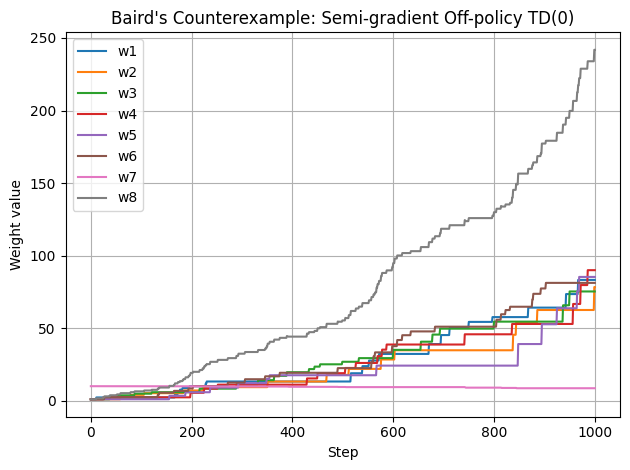

In [6]:
import numpy as np
import matplotlib.pyplot as plt

NUM_STATES = 7     # s1,...,s7
NUM_FEATURES = 8   # w1,...,w8

def build_feature_matrix():
    Phi = np.zeros((NUM_STATES, NUM_FEATURES))
    for i in range(6):
        Phi[i, i] = 2.0      # state-specific feature
        Phi[i, 7] = 1.0      # 8번째 좌표 (shared feature)
    # 아래 상태 s7: 7번째 좌표 1, 8번째 좌표 2
    Phi[6, 6] = 1.0
    Phi[6, 7] = 2.0
    return Phi

Phi = build_feature_matrix()

w_init = np.array([1, 1, 1, 1, 1, 1, 10, 1], dtype=float)
print("Initial state values:", Phi.dot(w_init))

def behavior_prob(action, state):
    # 모든 상태에서 μ(solid|s)=1/7, μ(dashed|s)=6/7
    return 1.0 / 7.0 if action == 0 else 6.0 / 7.0

def target_prob(action, state):
    # 타깃 정책은 항상 solid
    return 1.0 if action == 0 else 0.0

def sample_behavior_action(state, rng):
    if rng.random() < 1.0 / 7.0:
        return 0  # solid
    else:
        return 1  # dashed

def step(state, action, rng):
    """
    Baird 전이:
    어떤 상태 s에서든
      · solid -> 항상 s7 (index 6)
      · dashed -> {s1,...,s6} 중 하나로 균등 전이
    보상은 항상 0
    """
    if action == 0:          # solid
        next_state = 6       # s7
    else:                    # dashed
        next_state = rng.integers(0, 6)  # 0..5 중 하나
    reward = 0.0
    return next_state, reward

def semi_gradient_off_policy_td(
    num_steps=1000,
    alpha=0.01,
    gamma=0.99,
    seed=0
):
    rng = np.random.default_rng(seed)

    w = w_init.copy()
    ws = np.zeros((num_steps + 1, NUM_FEATURES))
    ws[0] = w
    state = rng.integers(0, NUM_STATES)

    for t in range(num_steps):
        action = sample_behavior_action(state, rng)
        next_state, reward = step(state, action, rng)

        v_s = Phi[state] @ w
        v_next = Phi[next_state] @ w

        delta = reward + gamma * v_next - v_s
        rho = target_prob(action, state) / behavior_prob(action, state)
        w = w + alpha * rho * delta * Phi[state]

        ws[t + 1] = w
        state = next_state

    return ws

def plot_weight_trajectories(ws):
    steps = np.arange(ws.shape[0])
    for i in range(NUM_FEATURES):
        plt.plot(steps, ws[:, i], label=f"w{i+1}")
    plt.xlabel("Step")
    plt.ylabel("Weight value")
    plt.title("Baird's Counterexample: Semi-gradient Off-policy TD(0)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    num_steps = 1000
    alpha = 0.01
    gamma = 0.99

    ws = semi_gradient_off_policy_td(
        num_steps=num_steps,
        alpha=alpha,
        gamma=gamma,
        seed=1   # 재현을 위해 고정
    )
    print("Final weights:", ws[-1])
    plot_weight_trajectories(ws)